In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
batch_size = 256
num_epochs = 200
learning_rate = 0.00015

d_noise  = 100
d_hidden = 256

In [4]:
# standardization code
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean= 0.5, std=0.5)
])  


# MNIST dataset
train_set = dsets.MNIST(root='data/', train=True, transform=transform, download=True)
test_set  = dsets.MNIST(root='data/', train=False, transform=transform, download=True)


train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True)

C:\Users\WorkStation\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


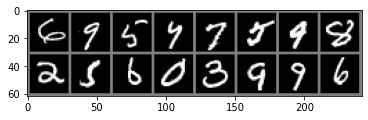

In [5]:
def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
def z(num_batch = 1, d_noise=100):
    return torch.randn(num_batch, d_noise, device=device)
    # 256 * 100
def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)


example_mini_batch_img, example_mini_batch_label = next(iter(train_loader))
imshow_grid(example_mini_batch_img[0:16])

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.generator = nn.Sequential(
            nn.Linear(d_noise, d_hidden),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(d_hidden,d_hidden),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(d_hidden, 28*28),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.generator(x)
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(28*28, d_hidden),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(d_hidden, d_hidden),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(d_hidden, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.discriminator(x)
        return x

In [7]:
criterion = nn.BCELoss()

def train_model(G, D, _optimizer_g, _optimizer_d):
    G.train()
    D.train()

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        _optimizer_d.zero_grad()

        p_real = D(x.view(-1, 28*28))
        p_fake = D(G(z(x.size(0), d_noise)))

        loss_real = -1 * torch.log(p_real)   # -1 for gradient ascending
        loss_fake = -1 * torch.log(1.-p_fake) # -1 for gradient ascending
        loss_d    = (loss_real + loss_fake).mean()

        loss_d.backward()
        _optimizer_d.step()

        # ======================== #
        
        _optimizer_g.zero_grad()

        p_fake = D(G(z(x.size(0), d_noise)))

        loss_g = -1 * torch.log(p_fake).mean()
        
        loss_g.backward()
        _optimizer_g.step()

def evaluate_model(G, D):
    p_real, p_fake = 0.,0.

    G.eval()
    D.eval()

    for x, y in test_loader:

        x, y = x.to(device), y.to(device)

        with torch.autograd.no_grad():
            p_real += (torch.sum(D(x.view(-1, 28*28))).item())/len(test_set)
            p_fake += (torch.sum(D(G(z(x.size(0), d_noise)))).item())/len(test_set)
    return p_real, p_fake

[epoch 50/500] p_real: 0.858076648235321, p_g: 0.18478562145233157


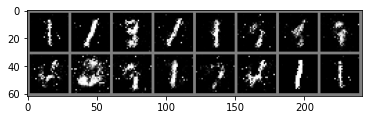

[epoch 100/500] p_real: 0.7953488648414613, p_g: 0.2172056374073029


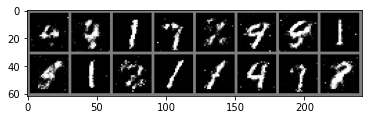

[epoch 150/500] p_real: 0.6989983039855957, p_g: 0.2693956959247589


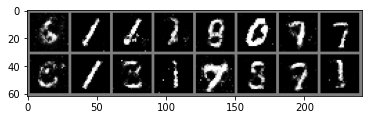

[epoch 200/500] p_real: 0.6335267293930053, p_g: 0.29855227298736564


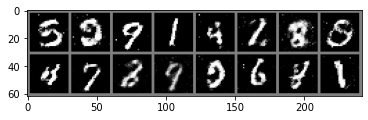

[epoch 250/500] p_real: 0.6281274461746217, p_g: 0.2761153574466705


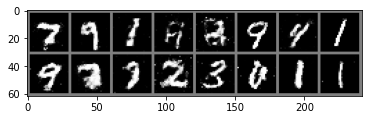

[epoch 300/500] p_real: 0.6346598449707033, p_g: 0.30010051102638235


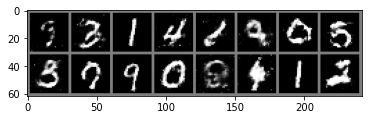

[epoch 350/500] p_real: 0.6157813508987428, p_g: 0.28619494333267215


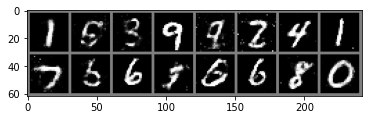

[epoch 400/500] p_real: 0.6065471044540405, p_g: 0.29839128155708317


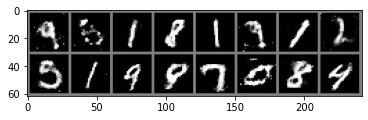

[epoch 450/500] p_real: 0.5738577730178833, p_g: 0.289630332660675


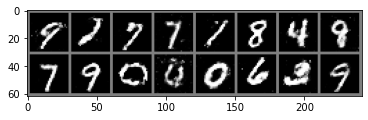

[epoch 500/500] p_real: 0.5693708933830263, p_g: 0.2922123436927796


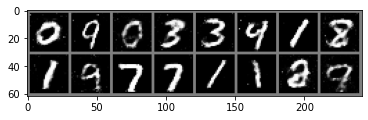

In [8]:
generator = Generator()
discriminator = Discriminator()
generator, discriminator = generator.to(device), discriminator.to(device)

init_params(generator)
init_params(discriminator)

optimizer_g = optim.Adam(generator.parameters(), lr = learning_rate)
optimizer_d = optim.Adam(discriminator.parameters(), lr = learning_rate)

p_real_trace = []
p_fake_trace = []

for epoch in range(num_epochs):
    train_model(generator, discriminator, optimizer_g, optimizer_d)
    p_real, p_fake = evaluate_model(generator,discriminator)

    p_real_trace.append(p_real)
    p_fake_trace.append(p_fake)

    if((epoch+1)% 50 == 0):
        print(f'[epoch {epoch+1}/{num_epochs}] p_real: {p_real}, p_g: {p_fake}')
        imshow_grid(generator(z(16)).view(-1, 1, 28, 28))

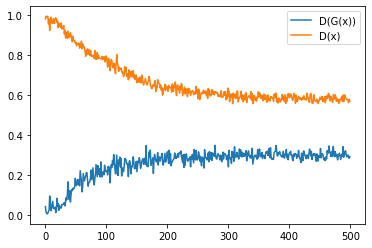

In [9]:
plt.plot(p_fake_trace, label='D(G(x))')
plt.plot(p_real_trace, label='D(x)')
plt.legend()

plt.show()

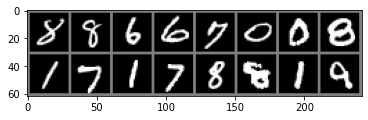

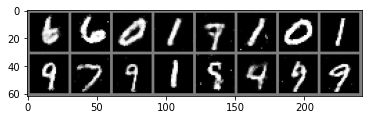

In [10]:
vis_loader = torch.utils.data.DataLoader(test_set, 16, True)
img_vis, label_vis   = next(iter(vis_loader))

imshow_grid(img_vis)
imshow_grid(generator(z(16,100)).view(-1, 1, 28, 28))